In [12]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 
import gzip
import timeit
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scripts.vectology_functions import create_aaa_distances, create_pair_distances, embed_text, encode_traits, create_efo_nxo

from pandas_profiling import ProfileReport

import seaborn as sns

# Apply the default theme
sns.set_theme()

In [4]:
# globals
ebi_data = 'data/UK_Biobank_master_file.tsv'
#efo_nodes = 'data/efo-nodes.tsv'
#efo_data = 'data/efo_data.txt.gz'
efo_nodes = 'data/epigraphdb_efo_nodes.csv'
efo_rels = 'data/epigraphdb_efo_rels.csv'
nxontology_measure = 'batet'

modelData = [
    {'name':'BioSentVec','model':'BioSentVec'},
    {'name':'BioBERT','model':'biobert_v1.1_pubmed'},
    {'name':'BlueBERT','model':'NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12'},
    {'name':'GUSE','model':'GUSEv4'},
    {'name':'BERT-EFO','model':'BERT-EFO'},
    {'name':'Zooma','model':'Zooma'}
]

pallete="hls"
output='output/trait-trait'

In [7]:
#create nxontology network of EFO relationships
efo_rel_df=pd.read_csv(efo_rels)
efo_nx = create_efo_nxo(df=efo_rel_df,child_col='efo.id',parent_col='parent_efo.id')
efo_nx.freeze()

In [8]:
# read cleaned EBI data
ebi_df = pd.read_csv('output/ebi-ukb-cleaned.tsv',sep='\t')
print(ebi_df.head())
print(ebi_df.shape)

#now we need one to one mappings of query and EFO, so drop duplicates
ebi_df_dedup = ebi_df.drop_duplicates(subset=['query'])
print(ebi_df_dedup.shape)

                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

  MAPPING_TYPE           id                               full_id  
0        Broad  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264  
1        Broad  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431  
2        Broad  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616  
3      ? Broad  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778  
4      ? Broad  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901  
(1303, 5)
(1240, 5)


In [7]:
%%time

# create nx score for each full_id

f = f"{output}/nx-ebi-pairs.csv.gz"
if os.path.exists(f):
    print('nx for ebi done')
else:
    o = gzip.open(f,'wb')
    o.write("q1\tq2\tscore\n".encode('utf-8'))
    efos = list(ebi_df_dedup['full_id'])
    for i in range(0,len(efos)-1):
        if i % 100 == 0:
            print(i)    
        for j in range(i,len(efos)):
            e1 = efos[i]
            e2 = efos[j]
            if e1 != e2:
                res = similarity = efo_nx.similarity(e1,e2).results()
                nx_val = res[nxontology_measure]
                #print(i,e1,e2,nx_val)
                o.write(f"{e1}\t{e2}\t{nx_val}\n".encode('utf-8'))
    o.close()
print('Done')

nx for ebi done
Done
CPU times: user 259 µs, sys: 288 µs, total: 547 µs
Wall time: 309 µs


In [8]:
%%time
# run all against all for EBI query data
m = modelData[0]
for m in modelData:
    name = m['name']
    f = f'output/{name}-ebi-encode.npy'
    if os.path.exists(f):
        print(m)
        dd = np.load(f'output/{name}-ebi-encode.npy')
        print(len(dd))
        aaa = create_aaa_distances(dd)
        np.save(f'{output}/{name}-ebi-aaa.npy',aaa)
        #print(len(aaa))
    else:
        print(f,'does not exist')


{'name': 'BioSentVec', 'model': 'BioSentVec'}
1303
Creating distances...
1303
1303
{'name': 'BioBERT', 'model': 'biobert_v1.1_pubmed'}
1303
Creating distances...
1303
1303
{'name': 'BlueBERT', 'model': 'NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12'}
1303
Creating distances...
1303
1303
{'name': 'GUSE', 'model': 'GUSEv4'}
1303
Creating distances...
1303
1303
output/BERT-EFO-ebi-encode.npy does not exist
output/Zooma-ebi-encode.npy does not exist
CPU times: user 2.37 s, sys: 125 ms, total: 2.5 s
Wall time: 2.61 s


In [ ]:
def write_to_file(model_name,pairwise_data):
    print('writing',model_name)
    f = f'{output}/{model_name}-ebi-query-pairwise.tsv.gz'
    if os.path.exists(f):
        print('Already done',f)
    else:
        
        fo = gzip.open(f,'w')
        fo.write("q1\tq2\tscore\n".encode('utf-8'))
        ebi_list = ebi_df['query']
        for i in range(0,len(ebi_list)):
            if i % 100 == 0:
                print(i)
            # write to file
            mCount=0
            for j in range(i,len(ebi_list)):
                if ebi_list[i] in dedup_query_list and ebi_list[j] in dedup_query_list:
                    #if i != j:
                    #print(pairwise_data[i],pairwise_data[j])
                    score = 1-pairwise_data[i][j]
                    fo.write(f"{ebi_list[i]}\t{ebi_list[j]}\t{score}\n".encode('utf-8'))
                    mCount+=1



dedup_query_list=list(ebi_df_dedup['query'])

# create pairwise files
for m in modelData:
    name = m['name']
    f = f'{output}/{name}-ebi-aaa.npy'
    if os.path.exists(f):
        dd = np.load(f'{output}/{name}-ebi-aaa.npy')
        #a=np.load('output/BioSentVec-ebi-aaa.npy')
        print(len(dd))
        #print(len(dd[0]))
        write_to_file(model_name=name,pairwise_data=dd)


In [ ]:
# format BERT EFO data
df = pd.read_csv(f'data/BERT-EFO-ebi-query-pairwise.csv.gz')
df.rename(columns={'text_1':'q1','text_2':'q2'},inplace=True)
df = df[df['q1'].isin(dedup_query_list) & df['q2'].isin(dedup_query_list)]
df.to_csv(f'{output}/BERT-EFO-ebi-query-pairwise.tsv.gz',compression='gzip',index=False,sep='\t')

In [ ]:
# test matrix
print(ebi_df.shape)
#ebi_df_dedup=ebi_df.drop_duplicates(subset=['query'])
#print(ebi_df_dedup.shape)
#head(n=10)['query'])[0:10]
e_list=list(ebi_df_dedup['full_id'][0:10])
#q_list
#print(q_list)
print(e_list)

#nx
nx_df = pd.read_csv(f'{output}/nx-ebi-pairs.csv.gz',sep='\t')
print(nx_df.head())
nx_df = nx_df[nx_df['q1'].isin(e_list) & nx_df['q2'].isin(e_list)]
print(nx_df.shape)

d = {}
for i,row in nx_df.iterrows():
    d[row['q1']][row['q2']]=row['score']
print(d)
#nx_df = nx_df.pivot(index='q1',columns='q2')
print(nx_df.head())
ax=sns.clustermap(nx_df)
ax.savefig(f"{output}/all-nx-{plot_kind}.pdf")

In [103]:
# not great idea for all data
def plot_clustermaps():
    for m in modelData:
        name = m['name']
        try:
            a=np.load(f'{output}/{name}-ebi-aaa.npy')
            d = pd.DataFrame(a)
            d = d.fillna(1)
            print(d.head())
            ax=sns.clustermap(d)
            ax.savefig(f"{output}/{name}-aaa.pdf")
        except:
            print(f'{name} error')

       0         1         2         3         4         5         6     \
0  0.000000  0.000000  0.894513  0.784244  0.882000  0.897761  0.827023   
1  0.000000  0.000000  0.894513  0.784244  0.882000  0.897761  0.827023   
2  0.894513  0.894513  0.000000  0.596793  0.829617  0.879176  0.881899   
3  0.784244  0.784244  0.596793  0.000000  0.837889  0.875036  0.837694   
4  0.882000  0.882000  0.829617  0.837889  0.000000  0.835641  0.880499   

       7         8         9     ...      1293      1294      1295      1296  \
0  0.705853  0.790682  0.772085  ...  0.814651  0.843897  0.787113  0.900859   
1  0.705853  0.790682  0.772085  ...  0.814651  0.843897  0.787113  0.900859   
2  0.813436  0.753541  0.774785  ...  0.916125  0.908964  0.867098  0.871673   
3  0.780676  0.764465  0.761836  ...  0.907093  0.932539  0.824051  0.837480   
4  0.828265  0.823837  0.913830  ...  0.881009  0.871733  0.907896  0.913102   

       1297      1298      1299      1300      1301      1302  
0  0

In [20]:

tSNE=TSNE(n_components=2)
a=np.load(f'{output}/BioSentVec-ebi-aaa.npy')
d = pd.DataFrame(a)
print(d.head())
d = d.fillna(1)
tSNE_result=tSNE.fit_transform(d)

       0         1         2         3         4         5         6     \
0  0.000000  0.000000  0.894513  0.784244  0.882000  0.897761  0.827023   
1  0.000000  0.000000  0.894513  0.784244  0.882000  0.897761  0.827023   
2  0.894513  0.894513  0.000000  0.596793  0.829617  0.879176  0.881899   
3  0.784244  0.784244  0.596793  0.000000  0.837889  0.875036  0.837694   
4  0.882000  0.882000  0.829617  0.837889  0.000000  0.835641  0.880499   

       7         8         9     ...      1293      1294      1295      1296  \
0  0.705853  0.790682  0.772085  ...  0.814651  0.843897  0.787113  0.900859   
1  0.705853  0.790682  0.772085  ...  0.814651  0.843897  0.787113  0.900859   
2  0.813436  0.753541  0.774785  ...  0.916125  0.908964  0.867098  0.871673   
3  0.780676  0.764465  0.761836  ...  0.907093  0.932539  0.824051  0.837480   
4  0.828265  0.823837  0.913830  ...  0.881009  0.871733  0.907896  0.913102   

       1297      1298      1299      1300      1301      1302  
0  0

                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

  MAPPING_TYPE           id                               full_id          x  \
0        Broad  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264  24.428087   
1        Broad  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431  24.428173   
2        Broad  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616  10.534208   
3      ? Broad  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778  12.201570   
4      ? Broad  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   0.070365   

           y  
0  25.927982  
1  25.928043  
2 -23.493382  
3 -18.467136  
4 -24.868484  


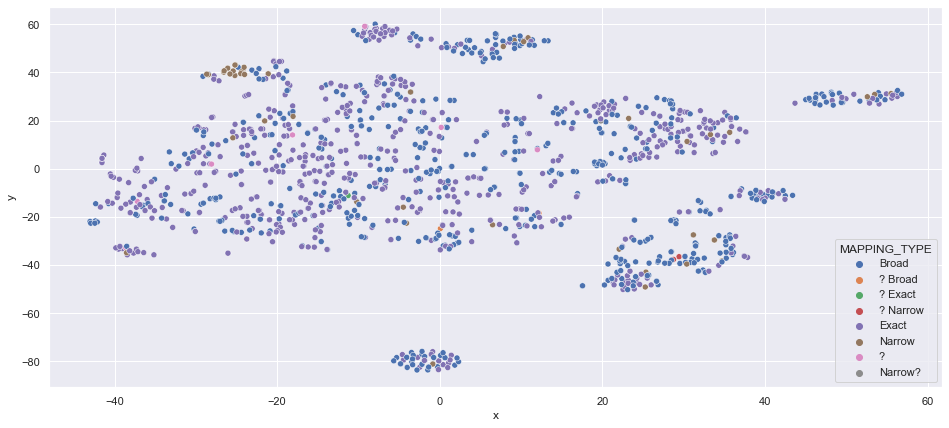

In [19]:
x=tSNE_result[:,0]
y=tSNE_result[:,1]
ebi_df['x']=x
ebi_df['y']=y
print(ebi_df.head())
plt.figure(figsize=(16,7))
sns.scatterplot(x='x',y='y',data=ebi_df, legend="full", hue="MAPPING_TYPE")
plt.savefig(f'{output}/tsne.pdf')